# Basic Transit Models

Now we have a folded light curve we can fit a transit model to it. There are several packages to do this, based on several models implementations. I will go through a basic example of how to 1) create a transit model using existing packages 2) fit that transit model with scipy. 

Transit model implementations:
* BATMAN
* PyTransit
* KTransit
* starry


Let's load the data that we're working with again. In the last notebook we already folded and found the period of the planet.

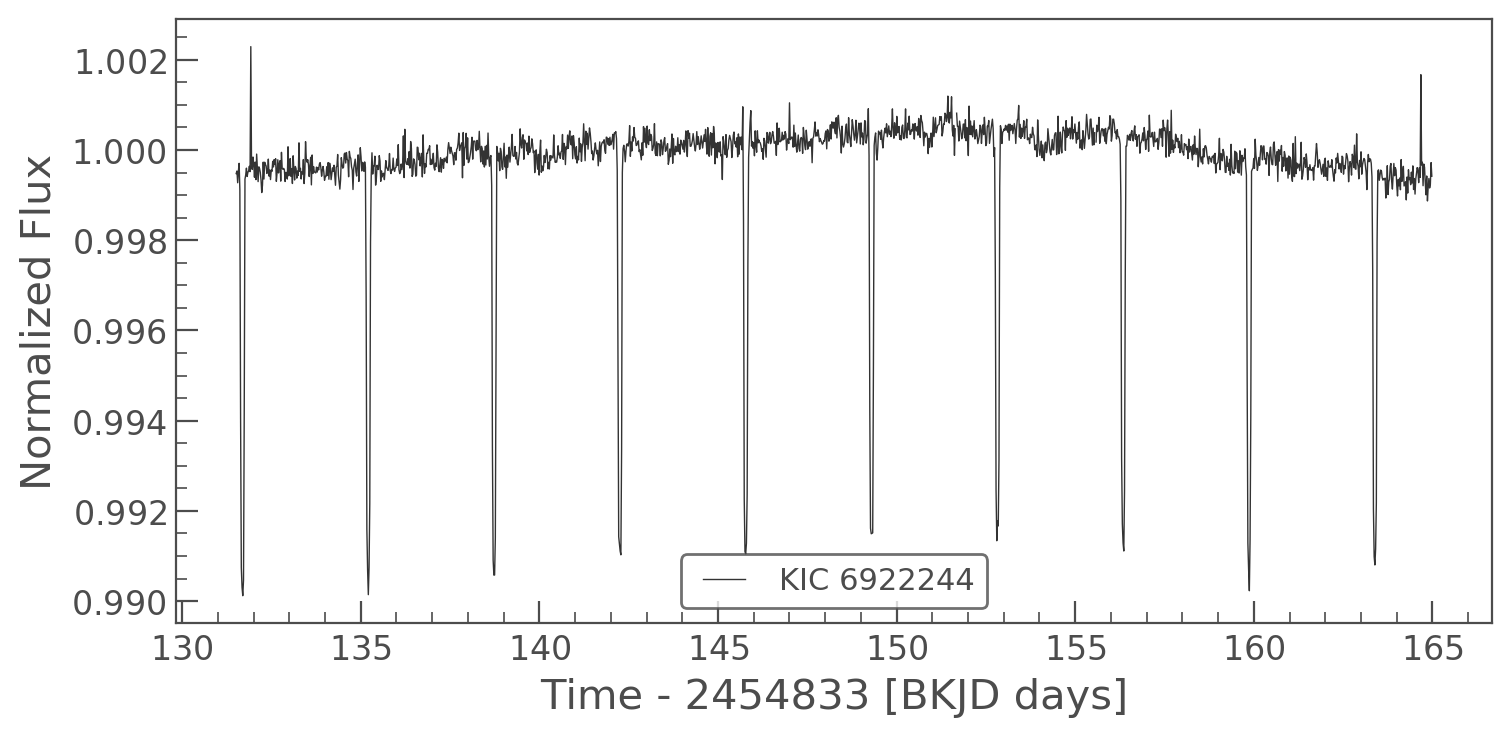

In [1]:
from lightkurve import KeplerLightCurveFile
import matplotlib.pyplot as plt
import numpy as np
lc = KeplerLightCurveFile.from_archive('Kepler-8', quality_mask='hard', quarter=1).PDCSAP_FLUX
lc.plot()

Now that we have limb darkening parameters we can build a transit model. In this case we're going to use [BATMAN](https://astro.uchicago.edu/~kreidberg/batman/installation.html) and [PyTransit](https://github.com/hpparvi/PyTransit). These packages are fairly easy to install and use and employs a Mandol and Agol (2002) model for transits. You can read more about transit models [here](transitmodels).

Firstly we will need to initialise our transit model. We will need the basic transit parameters to do this. 

We have already found the period in a previous notebook. We can find the transit center in this case quite easily by looking for the minimum of the smoothed, folded transit. This is shown below.

Finally we can set up the parameters for the planet itself. In *BATMAN* these parameters are $a/R_*$, $R_P/R_*$ and $i$:

* $a/R_*$ : The ratio of the orbital separation of the planet to the radius of the host star
* $R_P/R_*$ : The ratio of the planet radius to the host star radius
* $i$ : Inclination of the planets.


These are common parameters required for a transit model fit. For this planet we can obtain these parameters using NExSci, as we did a few notebooks ago.

In [2]:
from PyAstronomy import pyasl
import astropy.units as u
nexa = pyasl.NasaExoplanetArchive()
planet = nexa.selectByPlanetName('kepler-8 b')


# Inclination
i = planet['pl_orbincl']

# Planet radius. Note we add the unit 'jupiter radius' 
R_p = planet['pl_radj']*u.jupiterRad

# Star radius. We add the unit 'solar radius' and then convert to jupiter radii
R_st = (planet['st_rad']*u.solRad).to(u.jupiterRad)

# Planet orbital distance in AU. We convert this to jupiter radii too.
d = (planet['pl_orbsmax']*u.AU).to(u.jupiterRad)

# Planet Period
per = planet['pl_orbper']

# Transit midpoint
t0 = planet['pl_tranmid'] - 2454833.0

Now we can add these parameters into our models. Both BATMAN and PyTransit are shown below. More information on how to set them up can be found in their docs.

## BATMAN

In [3]:
import batman
params = batman.TransitParams()       #object to store transit parameters
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.5230, 0.1218]           #limb darkening coefficients
params.per = per                      #orbital period
params.t0 = t0
params.inc = i
params.rp = (R_p/R_st).value
params.a = (d/R_st).value

m = batman.TransitModel(params, np.asarray(lc.time, dtype=float))
batman_lc = m.light_curve(params) * np.nanmedian(lc.flux)

## PyTransit

PyTransit takes the following parameters in order.

* $R_P/R_*$
* Transit Mid Point
* Period
* $a/R_*$
* Inclination
* Eccentricity
* Argument of Periastron

In [4]:
from pytransit import MandelAgol
from math import pi
m = MandelAgol()


k, t0, p, a, inc, e, w = (R_p/R_st).value, t0, per, (d/R_st).value , (i*u.deg).to(u.rad).value, 0., 0.5*pi
pytransit_lc = MandelAgol().evaluate(lc.time, k, [0.5230, 0.1218], t0, p, a, inc, e, w) * np.nanmedian(lc.flux)

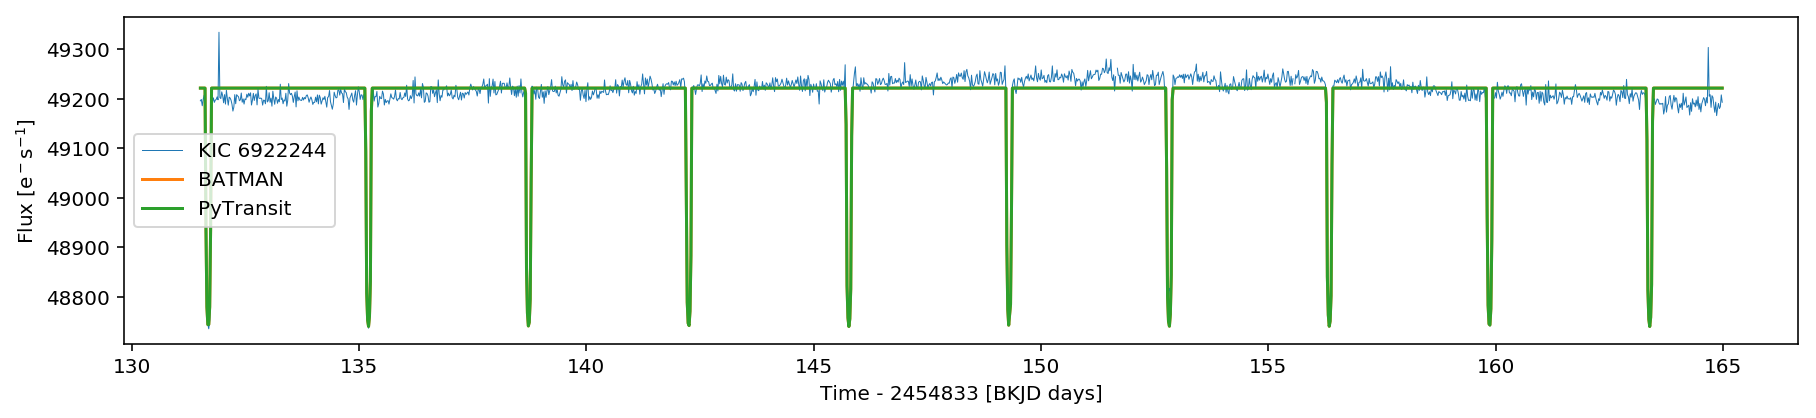

In [5]:
#Plot folded light curve with model.
fig, ax = plt.subplots(figsize=(15, 3))
lc.plot(ax=ax, normalize=False)
ax.plot(lc.time, batman_lc, zorder=1, label='BATMAN')
ax.plot(lc.time, pytransit_lc, zorder=2, label='PyTransit')
ax.legend()


In the next notebook we will look at how to fit these parameters rather than relying on NExSci.